In [1]:
!pip install -U scikit-learn

In [2]:
!pip install lightgbm

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

import lightgbm as lgb


import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid') 
plt.rcParams["figure.figsize"] = (12, 6)

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

<div style="background-color:#D2DCFA; padding:10px;">
    
# Описание задачи.
    
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.
    
# Описание даннных.
    
 - `datetime` с информацией о дате и времени заказа
    
 - `num_orders` с информацией о количестве заказов в указанный промежуток времени

## 1.Загрузка и ресемплирование данных

Прочитаем файл и выведем первые 5 строк. Установим в качестве индекса столбец с датой и прочитаем его сразу в формате datetime.

In [5]:
try:
    df = pd.read_csv(r'C:\Users\ilyal\OneDrive\Рабочий стол\Портфолио\practicum_projects\taxi_11\taxi.csv', 
                     parse_dates=[0],
                     index_col=[0])
except:
    df = pd.read_csv(r'/datasets/taxi.csv',
                     parse_dates=[0],
                     index_col=[0])
    
display(df.head())
display(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [6]:
df_hour = df.copy()

Проверим, упорядочена ли дата по возрастанию

In [7]:
df.index.is_monotonic_increasing

True

Проведем ресемплирование даты по одному часу и просуммируем количество заказов для этого часа

In [8]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## 2.Исследовательский анализ

Для начала проверим наш ряд на стационарность

Будем использовать сглаживание с помощью среднего и стандартного отклонения

In [9]:
df_hour['mean'] = df_hour['num_orders'].shift().rolling(24).mean()
df_hour['std'] = df_hour['num_orders'].shift().rolling(24).std()

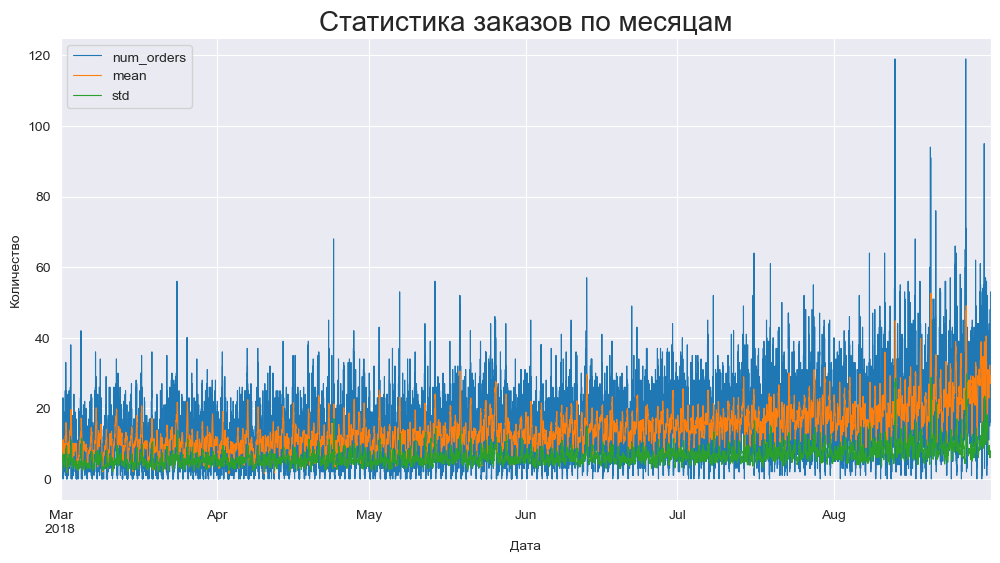

In [10]:
df_hour.plot(linewidth=0.8)
plt.title('Статистика заказов по месяцам', fontsize=20)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

Из графика выше видно, что наш ряд нестационарен и расширяется с Июля.

Проверим дополнительно наш ряд на стационарность с помощью теста Дики-Фуллера

- **H0** - ряд нестационарен

- **H1** - ряд стационарен

In [11]:
result = adfuller(df['num_orders'])

print('p-value:', result[1])

alpha = 0.01

if result[1] < alpha:
    print("Ряд стационарен, отклоняем нулевую гипотезу")
else:
    print("Ряд нестационарен, не отклоняем нулевую гипотезу")

p-value: 0.028940051402613506
Ряд нестационарен, не отклоняем нулевую гипотезу


Тест Дики-Фуллера дополнительно подтвердил нашу догадку о нестационарности ряда.

Проведем декомпозицию даты и посмотрим на тренд, сезонность и остатки

In [12]:
decomposed = seasonal_decompose(df.num_orders)

Посмотрим на общий тренд количества заказов за всё время

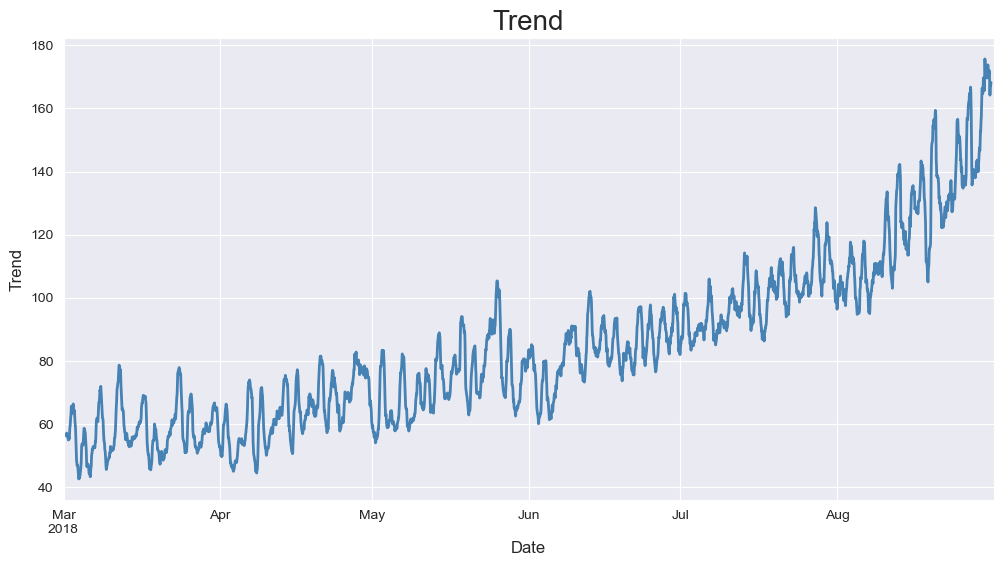

In [13]:
decomposed.trend.plot(ax=plt.gca(), grid=True, color='steelblue', linestyle='-', linewidth=2)
plt.title('Trend', fontsize=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Trend', fontsize=12)
plt.show()

На графике видно, что компания находится в постоянном развитии. График имеет тренд на рост числа заказов

Теперь посмотрим на график сезонности в рамках одной недели

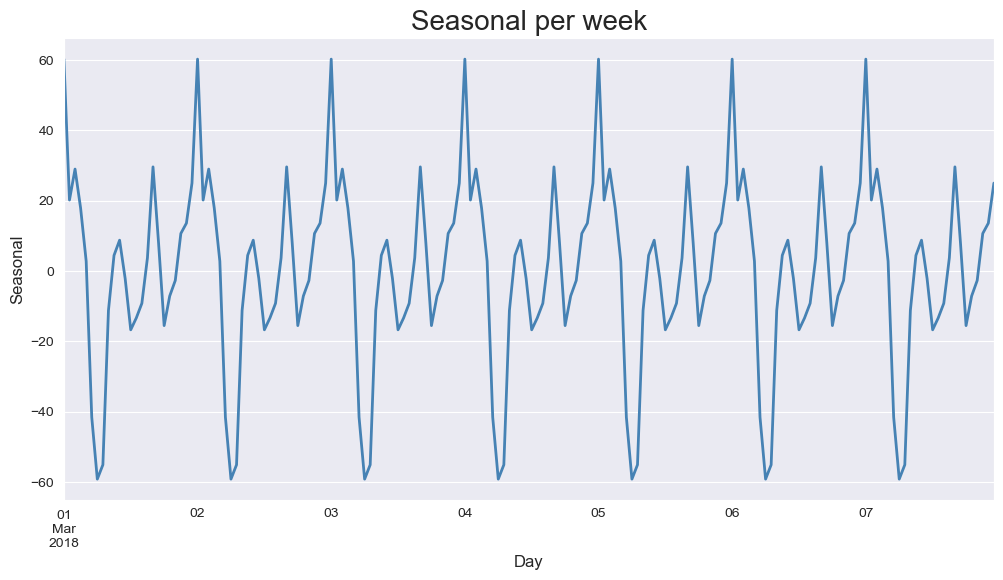

In [14]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca(), grid=True, color='steelblue', linewidth=2)
plt.title('Seasonal per week', fontsize=20)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Seasonal', fontsize=12)
plt.show()

Из графика видно, что в данных присутствует четкая сезонность по дням

Посмотрим на график сезонности в рамках одного дня для выявления закономерностей

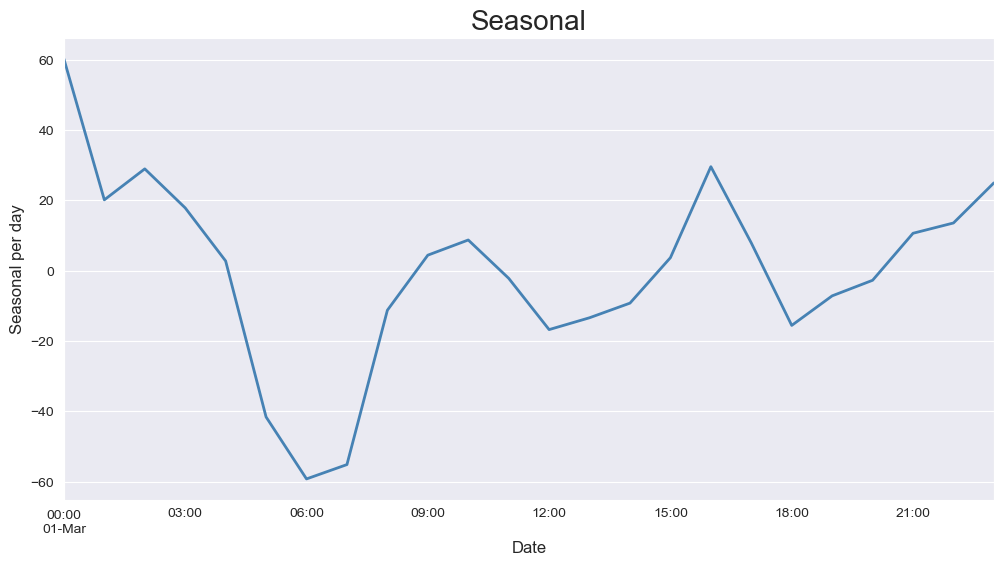

In [15]:
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(ax=plt.gca(), grid=True, color='steelblue', linewidth=2)
plt.title('Seasonal', fontsize=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seasonal per day', fontsize=12)
plt.show()

Из графика видно, что больше всего заказов с 16-18 и с 21-02

Посмотрим на график остатков

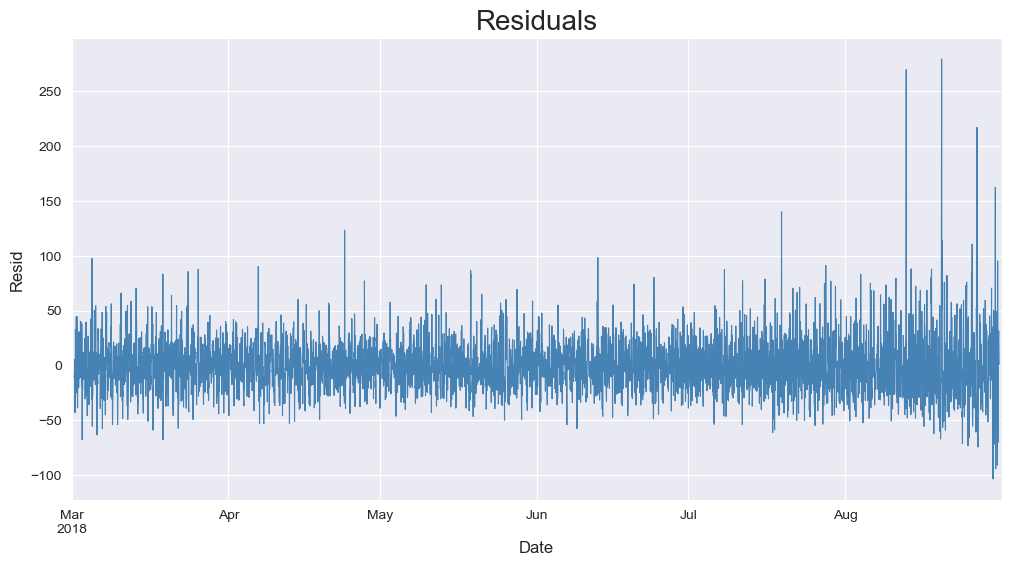

In [16]:
decomposed.resid.plot(ax=plt.gca(), grid=True, color='steelblue', linewidth=0.8)
plt.title('Residuals', fontsize=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Resid', fontsize=12)
plt.show()

График колеблется около нулевого значения, что является нормальной характеристикой остатков. В большинстве случаев остатки колеблются в диапазоне от -50 до 50. Однако начиная с июля, видны значительные выбросы и увеличение дисперсии остатков, что свидетельствует о увеличении нагрузки на оператора такси.

<div style="background-color:#D2DCFA; padding:10px;">
    
# Промежуточный вывод
    
Был проведен анализ ряда на стационарность:
    
 - исходя из анализа сглаженного среднего и стандартного отклонения был сделан вывод о нестационарности ряда
    
 - дополнительно проведен тест Дики-Фуллера, который показал, что ряд является нестационарным
    
    
Был проведен анализ сезонности, тренда и остатков, который показал, что:
    
 - компания находится в постоянном развитии. График тренда растущий
    
 - в данных присутствует четкая сезонность по дням, больше всего заказов с 16-18 и с 21-02
    
 - график остатков колеблется около нулевого значения, что является нормальной характеристикой остатков
   
 - в большинстве случаев остатки колеблются в диапазоне от -50 до 50. Однако начиная с июля, видны значительные выбросы и увеличение дисперсии остатков, что свидетельствует о увеличении нагрузки на оператора такси.

## 3.Обучение моделей

Добавим в датафрейм новые признаки. Выделим из даты год, месяц, день, день недели и час

In [17]:
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek

Так же добавим сдвиги на 10 часов.

In [18]:
for i in range(1, 11):
    df[f'lag_{i}'] = df['num_orders'].shift(i)

Так же добавим столбец со скользящим средним со сдвигом на 10 часов

In [19]:
df['rolling_mean'] = df['num_orders'].shift().rolling(10).mean()

In [20]:
df.head()

,num_orders,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df.describe()

,num_orders,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
count,4416.000000,4416.000000,4416.000000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4408.000000,4407.000000,4406.000000,4406.000000
mean,84.422781,15.836957,3.005435,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.236162,84.228954,84.217885,84.316841
std,45.023853,8.855229,1.990684,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,44.831888,44.834421,44.833486,29.695361
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000
25%,54.000000,8.000000,1.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.600000
50%,78.000000,16.000000,3.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,80.200000
75%,107.000000,23.250000,5.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,100.700000
max,462.000000,31.000000,6.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,213.400000


Разделим данные на обучающую и тестовую выборки

In [22]:
train, test = train_test_split(df, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()

In [23]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

Проверим, не попали ли данные из будущего в тестовую выборку

In [24]:
train.tail()

,num_orders,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-08-13 09:00:00,137,13,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,164.5
2018-08-13 10:00:00,156,13,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,159.7
2018-08-13 11:00:00,144,13,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,159.3
2018-08-13 12:00:00,92,13,0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,146.4
2018-08-13 13:00:00,119,13,0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,111.9


In [25]:
test.head()

,num_orders,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,13,0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,107.0
2018-08-13 15:00:00,175,13,0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,102.9
2018-08-13 16:00:00,144,13,0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,112.1
2018-08-13 17:00:00,152,13,0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,119.9
2018-08-13 18:00:00,104,13,0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,131.2


Данные разделены корректно

Обучим 2 модели: линейную регрессию и градиентный бустинг LightGBM

### LinearRegression

Напишем функцию для рассчета RMSE

In [26]:
def rmse(y_true, y_pred):
    return np.sqrt((y_true - y_pred) ** 2).mean()

In [27]:
model_lr = LinearRegression(n_jobs=-1)

Будем использовать GridSearchCV для кросс-валидации и TimeSeriesSplit для разбиения блоков валидации с учетом того, что данные представляют временной ряд и не будут перемешиваться как в обычной кросс-валидации

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

In [29]:
gs_linear = GridSearchCV(model_lr,
                         param_grid={},
                         scoring='neg_root_mean_squared_error',
                         cv=tscv,
                         n_jobs=-1)

Обучим поиск по сетке

In [30]:
gs_linear.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(n_jobs=-1), n_jobs=-1, param_grid={},
             scoring='neg_root_mean_squared_error')

Выведем метрику RMSE после кросс-валидации

In [31]:
print(f'RMSE LinearRegression CV: {abs(gs_linear.best_score_)}')

RMSE LinearRegression CV: 32.84230981570962


### LightGBM

In [32]:
model_lgbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)

In [33]:
parameters = {
    'num_leaves': [20, 30, 35],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 200]
}

In [34]:
gs_lgbm = GridSearchCV(model_lgbm,
                       parameters,
                       scoring='neg_root_mean_squared_error',
                       cv=tscv,
                       n_jobs=-1) 

In [35]:
gs_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2194
[LightGBM] [Info] Number of data points in the train set: 3964, number of used features: 13
[LightGBM] [Info] Start training from score 78.355701


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'n_estimators': [100, 200],
                         'num_leaves': [20, 30, 35]},
             scoring='neg_root_mean_squared_error')

In [36]:
print(f'RMSE for LightGBM CV: {abs(gs_lgbm.best_score_)}')

RMSE for LightGBM CV: 30.92299018996235


У модели метрика выше, чем у линейной регрессии. Для предсказания на тестовых данных выберем её

<div style="background-color:#D2DCFA; padding:10px;">
    
# Промежуточный вывод.
    
В данные было добавлено несколько признаков:
    
 - год, месяц, день и день недели
    
 - сдвиги на 10 часов максимум
    
 - скользящее среднее со сдвигом
    
Было обучено 2 модели:
    
 - LinearRegression с лучшим показателем RMSE на тренировочной выборке == 32.8
    
 - Модель градиентного бустинга LightGBM с лучшим показателем на тренировочной выборке == 30.9
    
Для предсказания выбрана модель градиентного бустинга LightGBM

## 4.Предсказания

Теперь сделаем предсказание для лучшей модели и посчитаем метрику RMSE на тестовых данных

In [37]:
lgbm_predict = gs_lgbm.best_estimator_.predict(X_test)
print(f'RMSE for LightGBM: {rmse(y_test, lgbm_predict)}')

RMSE for LightGBM: 41.9814014041809


У LightGBM метрика немного выше. Визуализируем предсказания и реальные значения на графике

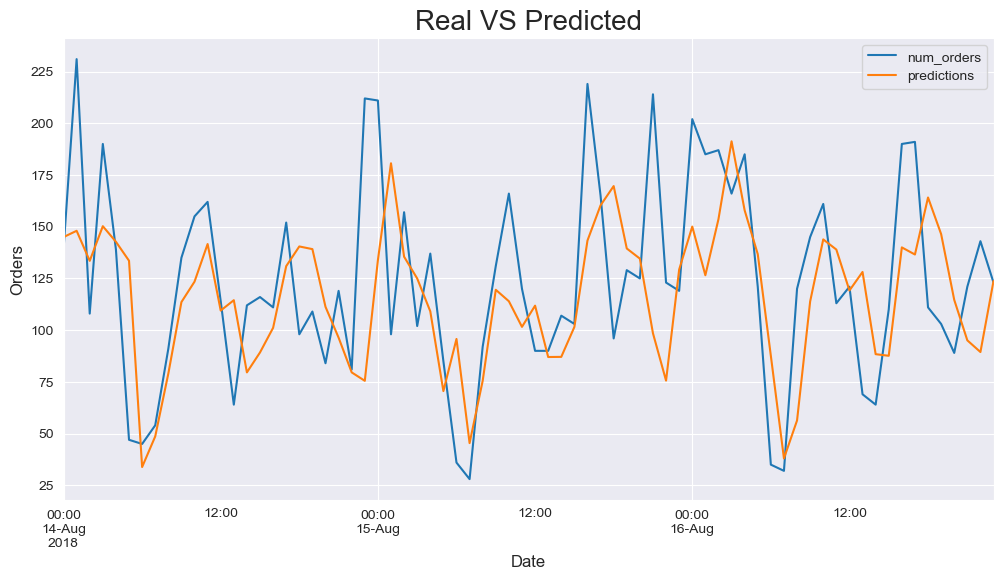

In [38]:
predictions_df = pd.DataFrame(data=lgbm_predict, columns=['predictions'], index=X_test.index.copy())
df_result = pd.merge(y_test, predictions_df, how='left', left_index=True, right_index=True)
df_result['2018-08-14':'2018-08-16'].plot()
plt.title('Real VS Predicted', fontsize=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Orders', fontsize=12)
plt.show()

Из графика видно, что модель достаточно хорошо предсказывает количество заказов по часам, неидеально, но очень даже близко к реальности, основные взлеты и падения спрогнозированы

<div style="background-color:#D2DCFA; padding:10px;">
    
# Промежуточный вывод
    
На тестовых данных модель LightGBM показала метрику:
    
 - LightGBM **41.9**
    
Был проведен анализ результатов прогнозирования
    
График показал, что:
    
 - модель достаточно хорошо предсказывает количество заказов по часам, неидеально, но очень даже близко к реальности, основные взлеты и падения спрогнозированы

---

<div style="background-color:#D2DCFA; padding:10px;">
    
# Вывод.
    
Был проведен анализ ряда на стационарность:
    
 - исходя из анализа сглаженного среднего и стандартного отклонения был сделан вывод о нестационарности ряда
    
 - дополнительно проведен тест Дики-Фуллера, который показал, что ряд является нестационарным
    
    
Был проведен анализ сезонности, тренда и остатков, который показал, что:
    
 - компания находится в постоянном развитии. График тренда растущий
    
 - в данных присутствует четкая сезонность по дням, больше всего заказов с 16-18 и с 21-02
    
 - график остатков колеблется около нулевого значения, что является нормальной характеристикой остатков
   
 - в большинстве случаев остатки колеблются в диапазоне от -50 до 50. Однако начиная с июля, видны значительные выбросы и увеличение дисперсии остатков, что свидетельствует о увеличении нагрузки на оператора такси.
    
---
    
В данные было добавлено несколько признаков:
    
 - день и день недели
    
 - сдвиги на 10 часов максимум
    
 - скользящее среднее со сдвигом
    
Было обучено 2 модели:
    
 - LinearRegression с лучшим показателем RMSE на тренировочной выборке == 32.8
    
 - Модель градиентного бустинга LightGBM с лучшим показателем на тренировочной выборке == 30.9
    
Для предсказания выбрана модель градиентного бустинга LightGBM
    
---
    
На тестовых данных модель LightGBM показала метрику:
    
 - LightGBM **41.9**
    
Был проведен анализ результатов прогнозирования
    
График показал, что:
    
 - модель достаточно хорошо предсказывает количество заказов по часам, неидеально, но очень даже близко к реальности, основные взлеты и падения спрогнозированы
    
---
    
С задачей заказчика справились успешно. Метрика RMSE **41.9**